# **Random Forest univariate model for the prediction of meteorological time series data.**

# **Autoregressive Random Forest for forecasting**
*Code used and adapted from reference*  **https://sarem-seitz.com/posts/forecasting-with-decision-trees-and-random-forests/**

## DATA WORK

In [21]:
## IMPORTING REQUIRED LIBRARIES
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt



---
Change the data file path with yours

In [22]:
# LOAD DATA

location = '/content/drive/MyDrive/Colab Notebooks/MACHINE LEARNING TESIS/TIME-SERIES-Diario-13-23.csv'  ## DAILY DATA
# location = '/content/drive/MyDrive/Colab Notebooks/MACHINE LEARNING TESIS/TIME-SERIES-Mensual-86-23.csv' ## MONTHLY DATA

data = pd.read_csv(location, parse_dates=['Fecha'],infer_datetime_format=True) # PARSE COLUMN "FECHA" TO DATE TYPE
data.head()

<ipython-input-22-4383ca02678b>:6: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(location, parse_dates=['Fecha'],infer_datetime_format=True) # PARSE COLUMN "FECHA" TO DATE TYPE


,Año,Mes,Dia,Fecha,Tｰ Media,TｰMaxima,TｰMinima,Lluvia,%Humedad
0,2013,Ene,1,2013-01-01,12.038,18.022,7.344,0.956,73.676
1,2013,Ene,2,2013-01-02,12.224,18.000,8.078,3.600,74.553
2,2013,Ene,3,2013-01-03,11.902,17.822,7.667,9.933,76.719
3,2013,Ene,4,2013-01-04,10.906,16.778,7.122,8.800,79.117
4,2013,Ene,5,2013-01-05,11.146,16.267,7.211,4.956,79.746


In [23]:
# DATA INDEX
data = data.set_index(['Fecha'])

# CHANGE HEADER NAMES
data = data.rename(columns={"Tｰ Media": "Temp_media", "TｰMaxima": "Temp_max", "TｰMinima": "Temp_min", "Lluvia": "Precipitacion", "%Humedad": "Humedad" })



---
SELECT THE TARGET VARIABLE TO BE USED


In [24]:
# DROP COLUMNS THAT ARE NOT GOING TO BE USED
data = data.drop(["Año", "Dia", "Mes", "Temp_media", "Humedad", "Precipitacion", "Temp_min"], axis=1) # DAILY MAXIMUM TEMPERATURE DATA FRAME
# data = data.drop(["Año", "Mes", "Temp_media", "Humedad", "Temp_min", "Precipitacion"], axis=1)# # MONTHLY MAXIMUM TEMPERATURE DATA FRAME

data.head()

,Temp_max
Fecha,
2013-01-01,18.022
2013-01-02,18.000
2013-01-03,17.822
2013-01-04,16.778
2013-01-05,16.267


### DATA FEATURES (LAGS)

In [25]:
# CREATE FEATURES OF TIME SERIES (lagS)
def create_lag_features(data, n_lags):
    for lag in range(1, n_lags + 1):
        data[f'lag_{lag}'] = data['Temp_max'].shift(lag)  ## NAME OF THE TARGET VARIABLE
    return data

# SET NUMBER OF LAGS
n_lags = 15
data = create_lag_features(data, n_lags)
data.dropna(inplace=True)

# ADD SEASONAL FEATURES
data['Month'] = data.index.month
data['Day_of_Week'] = data.index.dayofweek

# SPLIT FEATURES AND TAGS
X = data.drop('Temp_max', axis=1)
y = data['Temp_max']

## SPLIT DATA

In [26]:
# DATA SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# CHECK DATASET SHAPE
print("Forma de X_train:", X_train.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_test:", y_test.shape)

Forma de X_train: (3094, 17)
Forma de y_train: (3094,)
Forma de X_test: (774, 17)
Forma de y_test: (774,)


In [27]:
# IN CASE YOU WANT TO USE SOME PARAMETERS OPTIMIZATION "GridSearchCV"
# param_grid = {
#     'n_estimators': [50, 100, 200, 500, 1000],
#     'max_depth': [5, 10, 20, 50, 100, None],
#     'min_samples_split': [2, 5, 10, 20, 30, 50, 100, 150],
#     'min_samples_leaf': [1, 2, 4, 6, 8, 10],
#     'bootstrap': [True, False]
# }

# # RANDOM FOREST CONFIGURATION
# rf = RandomForestRegressor(random_state=42)

# # RANDOMIZED SEARCH CV
# rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
#                                n_iter=100, cv=3, verbose=2, random_state=None, n_jobs=-1)

# # FIT MODEL
# rf_random.fit(X_train, y_train)

# # BEST ESTIMATOR
# best_rf = rf_random.best_estimator_

# print("BEST HYPERPARAMETERS:", rf_random.best_params_)

## MODEL BUILD

In [28]:
# INITIAL RANDOM FOREST CONFIGURATION
model = RandomForestRegressor(max_depth=5, n_estimators= 1000, min_samples_split= 30, min_samples_leaf= 4, bootstrap= True, oob_score=True) # CHANGE WITH YOUR PARAMETERS

In [29]:
# MODEL FIT
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=4, min_samples_split=30,
                      n_estimators=1000, oob_score=True)

### EVALUATIONS

In [30]:
# PREDICTIONS
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# EVALUATION
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape

# EVALUATE TRAIN SET
rmse_train, mae_train, mape_train = evaluate_model(y_train, y_pred_train)

# EVALUATE TEST SET
rmse_test, mae_test, mape_test = evaluate_model(y_test, y_pred_test)

# PRINT METRICS
print(f'TRAIN - RMSE: {rmse_train:.5f}, MAE: {mae_train:.5f}, MAPE: {mape_train:.5f}%')
print(f'TEST - RMSE: {rmse_test:.5f}, MAE: {mae_test:.5f}, MAPE: {mape_test:.5f}%')

TRAIN - RMSE: 1.59407, MAE: 1.22227, MAPE: 7.21878%
TEST - RMSE: 1.73306, MAE: 1.31420, MAPE: 7.49195%


## GRAPHICS

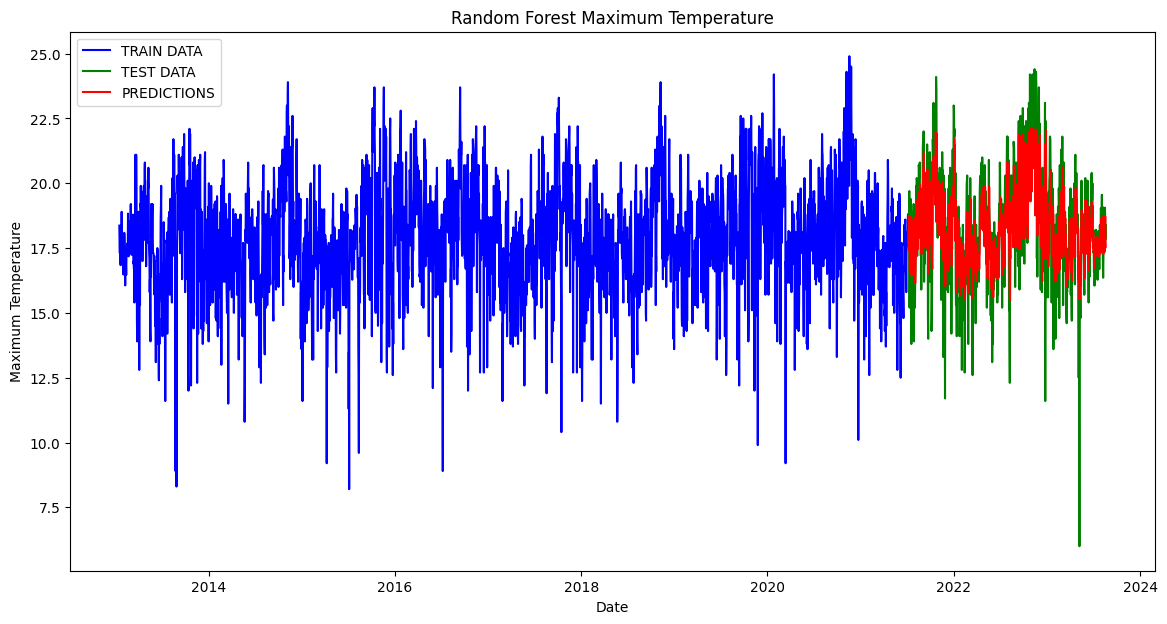

In [31]:
# TRAIN, TEST AND PREDICTIONS VISUALIZATION
plt.figure(figsize=(14, 7))
plt.plot(y_train.index, y_train, label='TRAIN DATA', color='b')
plt.plot(y_test.index, y_test, label='TEST DATA', color='g')
plt.plot(y_test.index, y_pred_test, label='PREDICTIONS', color='r', linestyle='-')
plt.title('Random Forest Maximum Temperature')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature')
plt.legend()
plt.show()

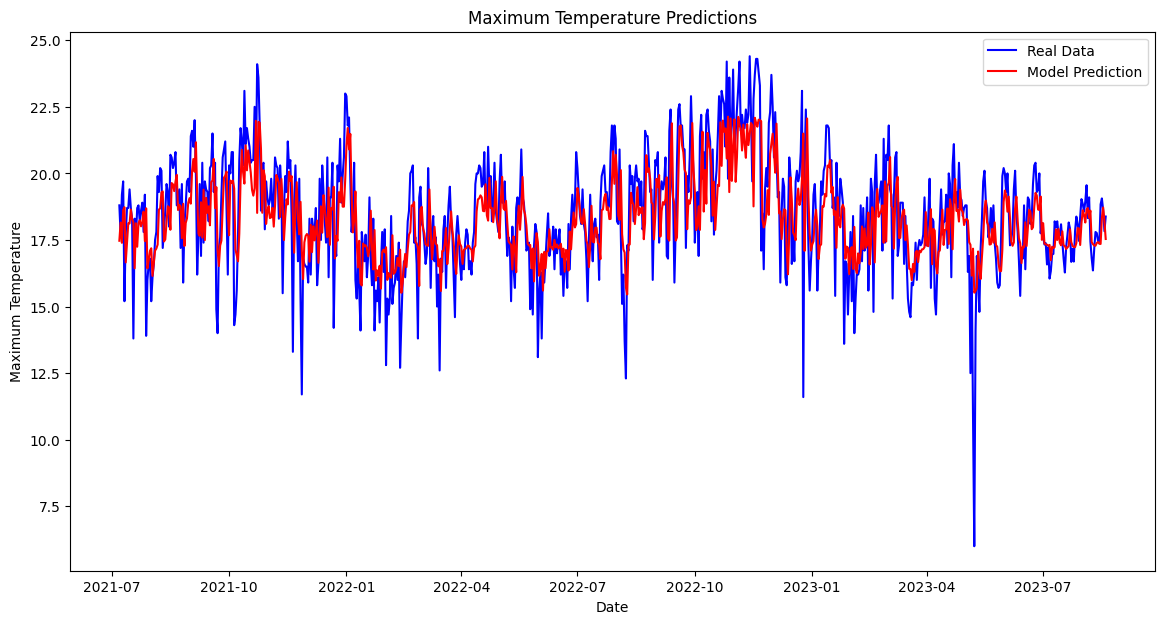

In [32]:
# Gráfica de comparación
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Real Data', color='b')
plt.plot(y_test.index, y_pred_test, label='Model Prediction', color='r')
plt.title('Maximum Temperature Predictions')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature')
plt.legend()
plt.show()

### Future Predictions

In [ ]:
# DRAW FORWARD PREDICTIONS (FOR DATA THAT DOESN'T EXIST)
def predict_future(model, last_observation, n_steps):
    future_predictions = []
    current_observation = last_observation.copy()

    for _ in range(n_steps):
        prediction = model.predict(current_observation.values.reshape(1, -1))[0]
        future_predictions.append(prediction)

        # UPDATE THE ACTUAL OBSERVATION WITH THE NEW PREDICTION
        new_row = np.roll(current_observation.values, -1)
        new_row[-1] = prediction
        current_observation = pd.Series(new_row, index=current_observation.index)

    return future_predictions

# FORWARD PREDICTIONS
n_future_steps = 365 ## SET FUTURES DAYS OR MONTHS TO PREDICT
last_observation = X_test.iloc[-1]  # LAST TEST SET OBSERVATION
future_predictions = predict_future(model, last_observation, n_future_steps)

# FUTURE PREDICTIONS VISUALIZATION
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=n_future_steps, freq='D') ## FOR DAILY PREDICTIONS
# future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=n_future_steps, freq='M') ## FOR MONTHLY PREDICTIONS

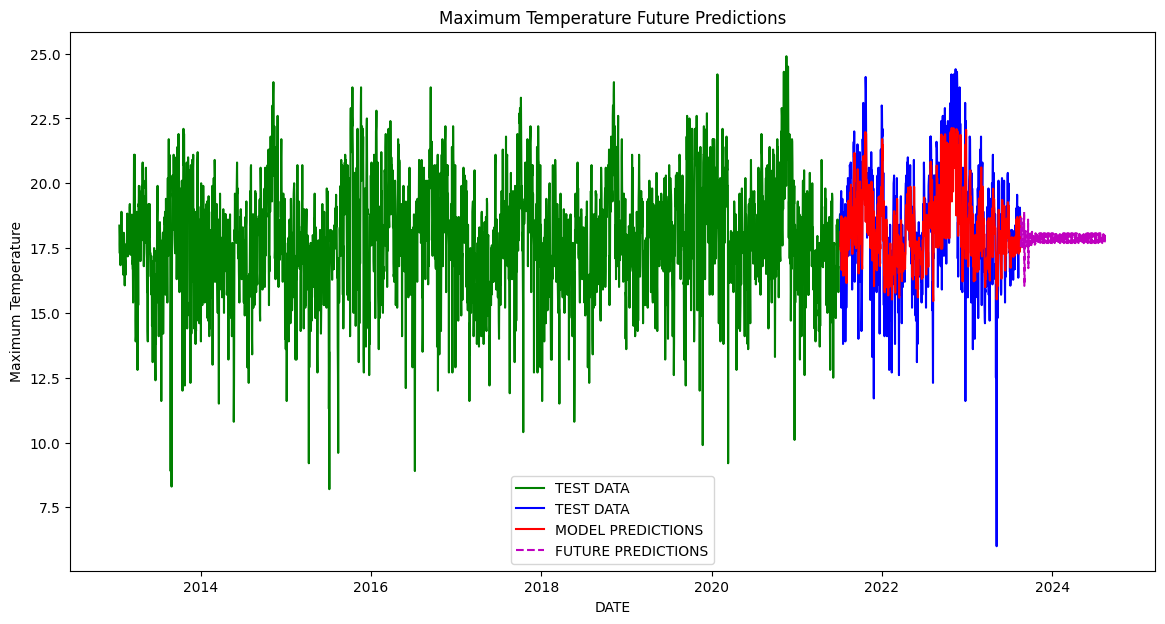

In [34]:
plt.figure(figsize=(14, 7))
plt.plot(y_train.index, y_train, label='TEST DATA', color='g')
plt.plot(y_test.index, y_test, label='TEST DATA', color='b')
plt.plot(y_test.index, y_pred_test, label='MODEL PREDICTIONS', color='r')
plt.plot(future_dates, future_predictions, label='FUTURE PREDICTIONS', color='m', linestyle='--')
plt.title('Maximum Temperature Future Predictions')
plt.xlabel('DATE')
plt.ylabel('Maximum Temperature')
plt.legend()
plt.show()

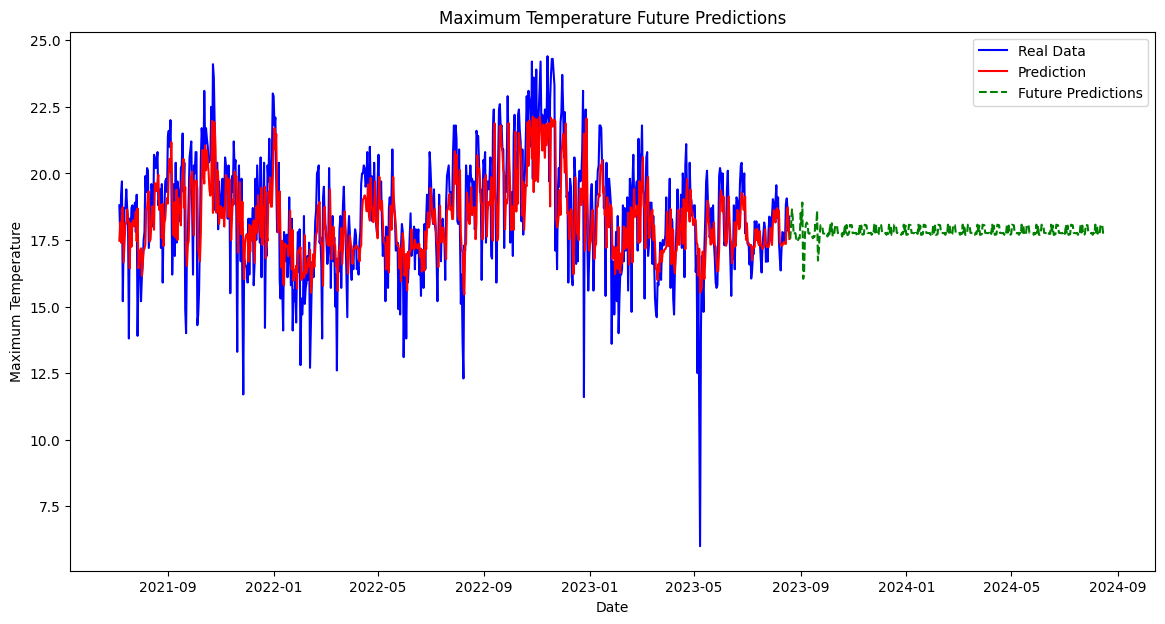

In [35]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Real Data', color='b')
plt.plot(y_test.index, y_pred_test, label='Prediction', color='r')
plt.plot(future_dates, future_predictions, label='Future Predictions', color='g', linestyle='--')
plt.title('Maximum Temperature Future Predictions')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature')
plt.legend()
plt.show()

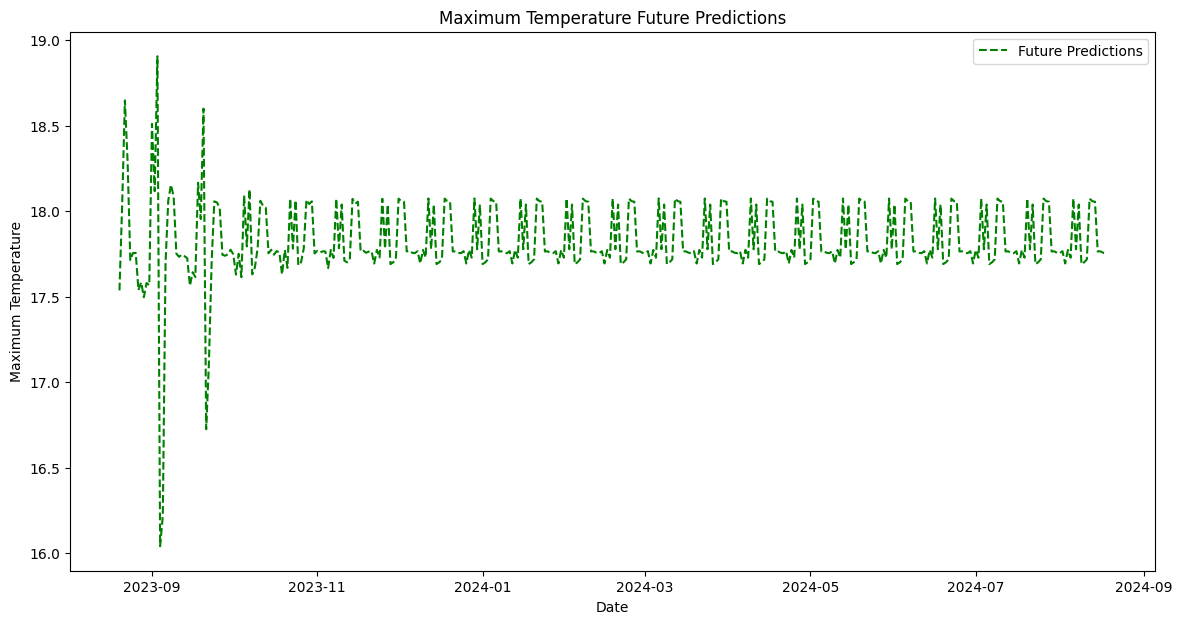

In [36]:
plt.figure(figsize=(14, 7))
plt.plot(future_dates, future_predictions, label='Future Predictions', color='g', linestyle='--')
plt.title('Maximum Temperature Future Predictions')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature')
plt.legend()
plt.show()

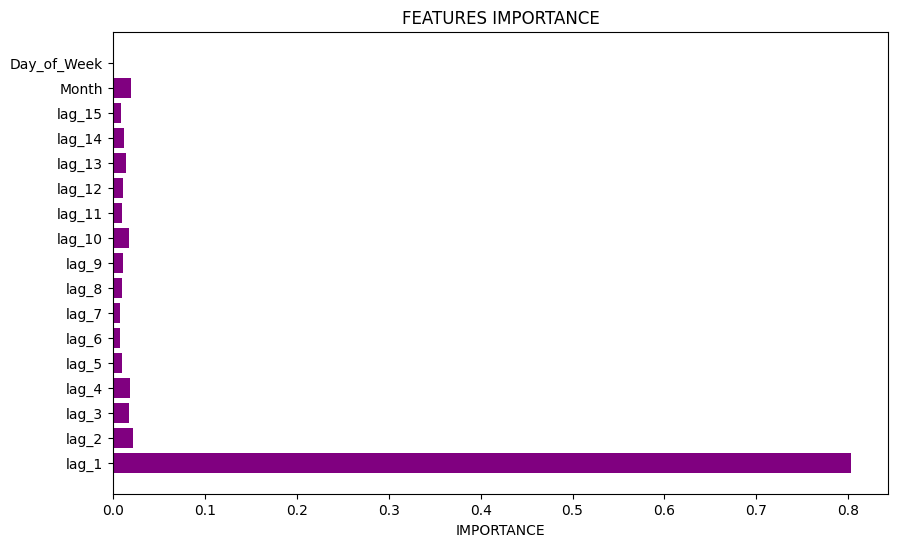

In [37]:
# FEATURES IMPORTANCE
feature_importances = model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances, color="purple")
plt.xlabel("IMPORTANCE")
plt.title("FEATURES IMPORTANCE")
plt.show()